## Importar librerias

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.metrics import confusion_matrix
import os
import pandas as pd
import glob
from matplotlib import cm
import scipy.io.wavfile
import sys


## Carga de audio con Librosa

In [2]:
data, sampling_rate = librosa.load('RawData/YAF_white_disgust.wav') #Mono
data2, sampling_rate2 = librosa.load('RawData/YAF_white_disgust.wav', mono=False) #Stereo

## Cálculo Espectograma

In [3]:
hop_length=160

# Calcular el espectrograma de STFT (Short Time Fourier Transform)
stft = librosa.stft(data, hop_length=hop_length)
D = np.abs(librosa.stft(data))

stft_db = librosa.amplitude_to_db(D, ref=np.max)

## Waveshow

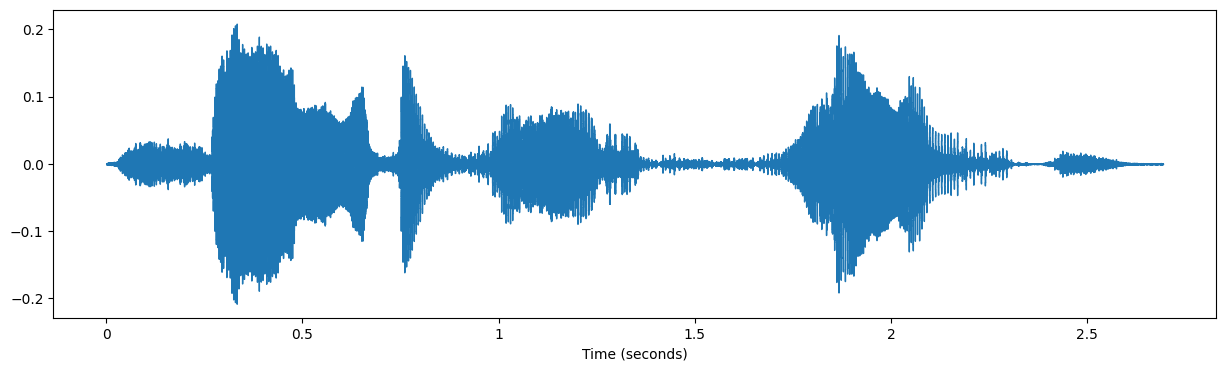

In [4]:
plt.figure(figsize=(15, 4))
librosa.display.waveshow(data, sr=sampling_rate, axis='s')
plt.show()

## Onset Strength

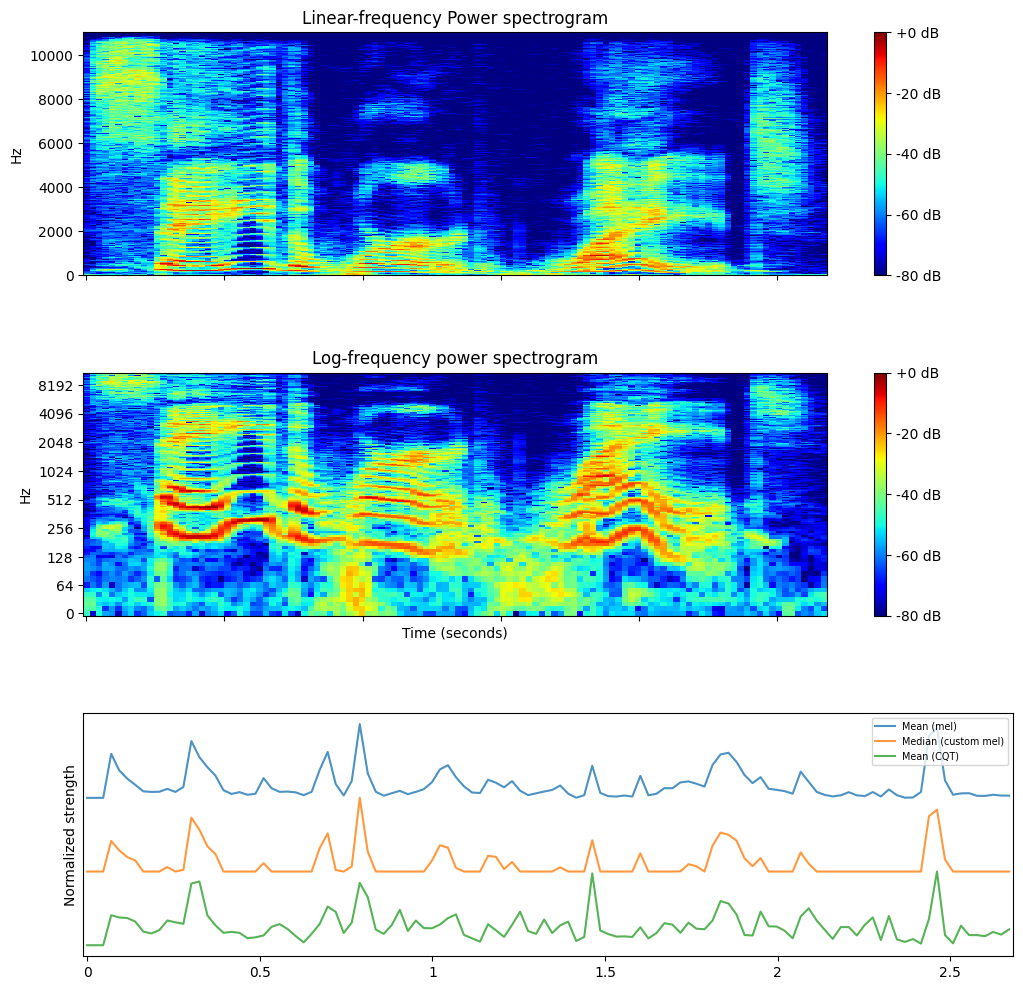

In [5]:

# Crear tiempos
times = librosa.times_like(D, sr=sampling_rate)

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(12, 12))

# Graficar espectrograma
img1 = librosa.display.specshow(stft_db, y_axis='linear', x_axis='s', ax=ax[0], cmap=cm.jet)
ax[0].set(title='Linear-frequency Power spectrogram')
ax[0].label_outer()
fig.colorbar(img1, ax=ax[0], format='%+2.0f dB')

# Graficar log power spectrogram
img2 = librosa.display.specshow(stft_db, y_axis='log', sr=sampling_rate, x_axis='s', ax=ax[1], cmap=cm.jet)
ax[1].set(title='Log-frequency power spectrogram')
fig.colorbar(img2, ax=ax[1], format='%+2.0f dB')

# Construcción de una función onset estándar
onset_env = librosa.onset.onset_strength(y=data, sr=sampling_rate)
ax[2].plot(times, 2 + onset_env / onset_env.max(), alpha=0.8, label='Mean (mel)')

# Agregar mediana y "custom mel"
onset_env = librosa.onset.onset_strength(y=data, sr=sampling_rate, aggregate=np.median, fmax=8000, n_mels=256)
ax[2].plot(times, 1 + onset_env / onset_env.max(), alpha=0.8, label='Median (custom mel)')

# Constant-Q spectrogram en vez de Mel
C = np.abs(librosa.cqt(y=data, sr=sampling_rate))
onset_env = librosa.onset.onset_strength(sr=sampling_rate, S=librosa.amplitude_to_db(C, ref=np.max))
ax[2].plot(times, onset_env / onset_env.max(), alpha=0.8, label='Mean (CQT)')
ax[2].legend(loc='upper right', fontsize='x-small')
ax[2].set(ylabel='Normalized strength', yticks=[])

# Ajustar el espacio entre subplots
plt.subplots_adjust(hspace=0.4)  # Ajusta el valor según sea necesario

# Ajustar el diseño para evitar solapamientos
#fig.tight_layout()

# Mostrar la gráfica
plt.show()


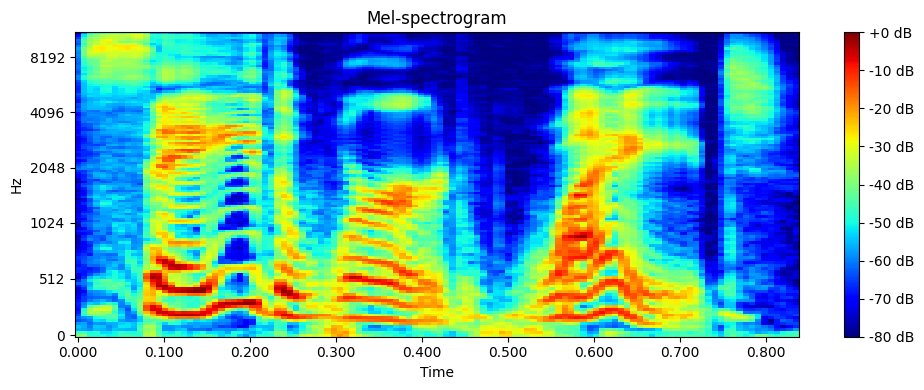

In [6]:
# Compute the mel-spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sampling_rate)

# Compute the Mel-frequency cepstral coefficients (MFCCs)
mfccs = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrogram), sr=sampling_rate)

# Plot the mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), sr=sampling_rate, hop_length=hop_length, y_axis="mel", x_axis="time", cmap=cm.jet)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel-spectrogram")
plt.tight_layout()
plt.show()


## Tempogram

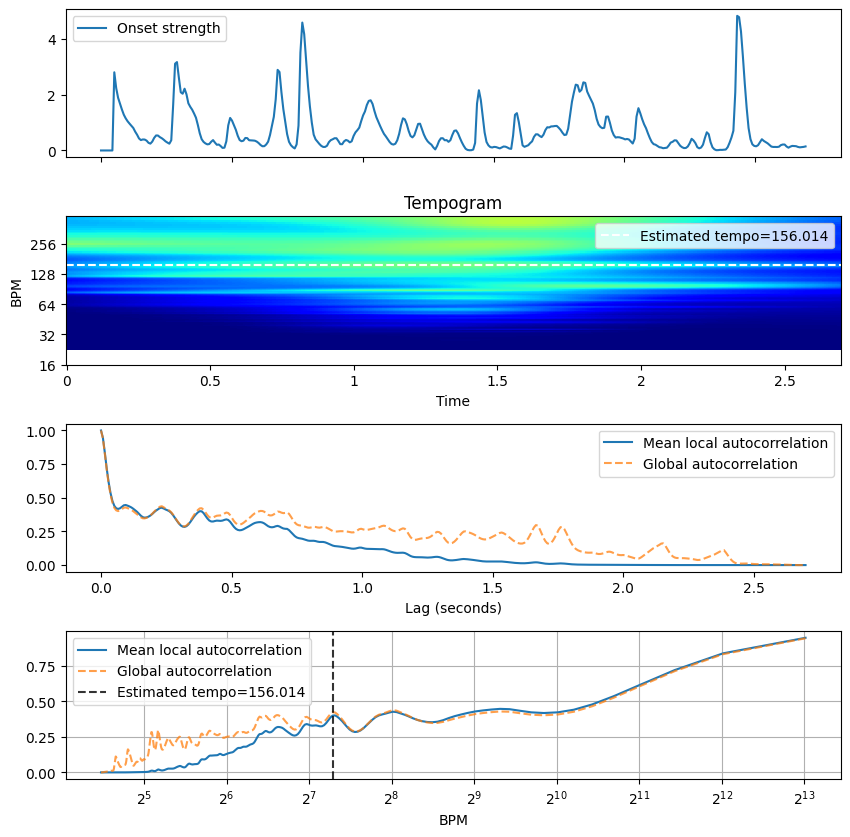

In [7]:
# Compute local onset autocorrelation
oenv = librosa.onset.onset_strength(y=data, sr=sampling_rate, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sampling_rate,
                                      hop_length=hop_length, win_length=oenv.shape[0])
# Compute global onset autocorrelation
ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
ac_global = librosa.util.normalize(ac_global)
# Estimate the global tempo for display purposes
tempo = librosa.feature.tempo(onset_envelope=oenv, sr=sampling_rate, tg=tempogram, hop_length=hop_length)[0]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=4, figsize=(10, 10))
times = librosa.times_like(oenv, sr=sampling_rate, hop_length=hop_length)
ax[0].plot(times, oenv, label='Onset strength')
ax[0].label_outer()
ax[0].legend(frameon=True)
librosa.display.specshow(tempogram, sr=sampling_rate, hop_length=hop_length,
                         x_axis='time', y_axis='tempo', cmap=cm.jet,
                         ax=ax[1])
ax[1].axhline(tempo, color='w', linestyle='--', alpha=1,
            label='Estimated tempo={:g}'.format(tempo))
ax[1].legend(loc='upper right')
ax[1].set(title='Tempogram')
x = np.linspace(0, tempogram.shape[0] * float(hop_length) / sampling_rate,
                num=tempogram.shape[0])
ax[2].plot(x, np.mean(tempogram, axis=1), label='Mean local autocorrelation')

ax[2].plot(x, ac_global, '--', alpha=0.75, label='Global autocorrelation')
ax[2].set(xlabel='Lag (seconds)')
ax[2].legend(frameon=True)
freqs = librosa.tempo_frequencies(tempogram.shape[0], hop_length=hop_length, sr=sampling_rate)
ax[3].semilogx(freqs[1:], np.mean(tempogram[1:], axis=1),
             label='Mean local autocorrelation', base=2)
ax[3].semilogx(freqs[1:], ac_global[1:], '--', alpha=0.75,
             label='Global autocorrelation', base=2)
ax[3].axvline(tempo, color='black', linestyle='--', alpha=.8,
            label='Estimated tempo={:g}'.format(tempo))
ax[3].legend(frameon=True)
ax[3].set(xlabel='BPM')
ax[3].grid(True)

# Ajustar el espacio entre subplots
plt.subplots_adjust(hspace=0.4)  # Ajusta el valor según sea necesario
plt.show()

## Plotting a transposed wave along with a self-similarity matrix

C:\Users\bianc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=928
  warnings.warn(


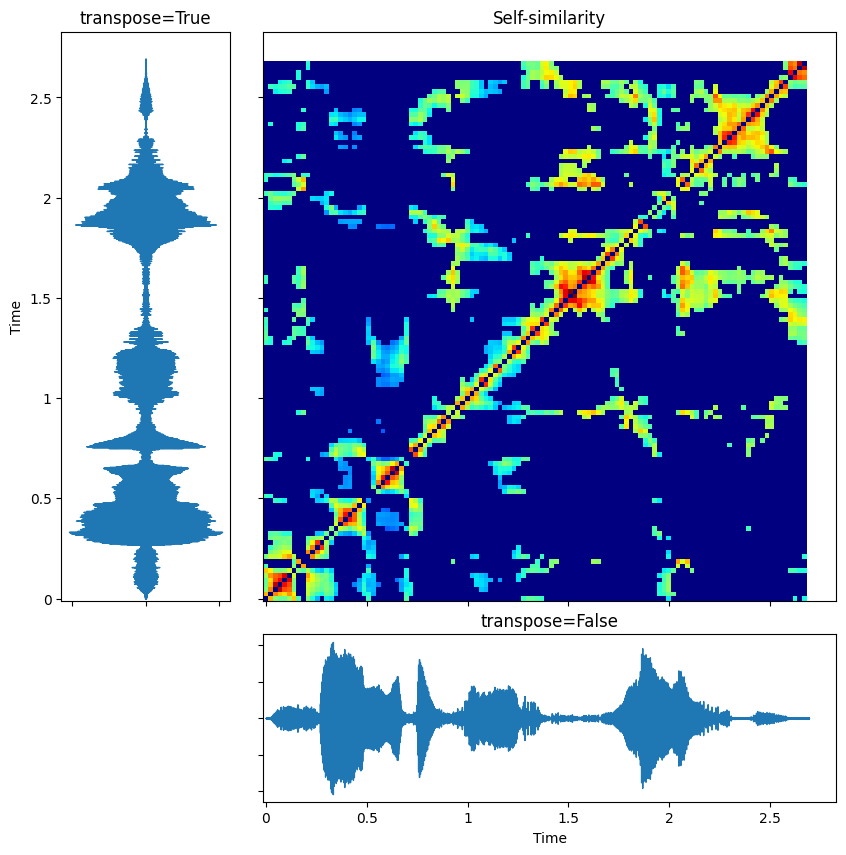

In [8]:
fig, ax = plt.subplot_mosaic("hSSS;hSSS;hSSS;.vvv", figsize=(10,10))
chroma = librosa.feature.chroma_cqt(y=data, sr=sampling_rate)
sim = librosa.segment.recurrence_matrix(chroma, mode='affinity')
librosa.display.specshow(sim, ax=ax['S'], sr=sampling_rate,
                         x_axis='time', y_axis='time',
                         auto_aspect=False, cmap=cm.jet)
ax['S'].label_outer()
ax['S'].sharex(ax['v'])
ax['S'].sharey(ax['h'])
ax['S'].set(title='Self-similarity')
librosa.display.waveshow(data, ax=ax['v'])
ax['v'].label_outer()
ax['v'].set(title='transpose=False')
librosa.display.waveshow(data, ax=ax['h'], transpose=True)
ax['h'].label_outer()
ax['h'].set(title='transpose=True')

plt.show()

## Plot a monophonic waveform with an envelope view

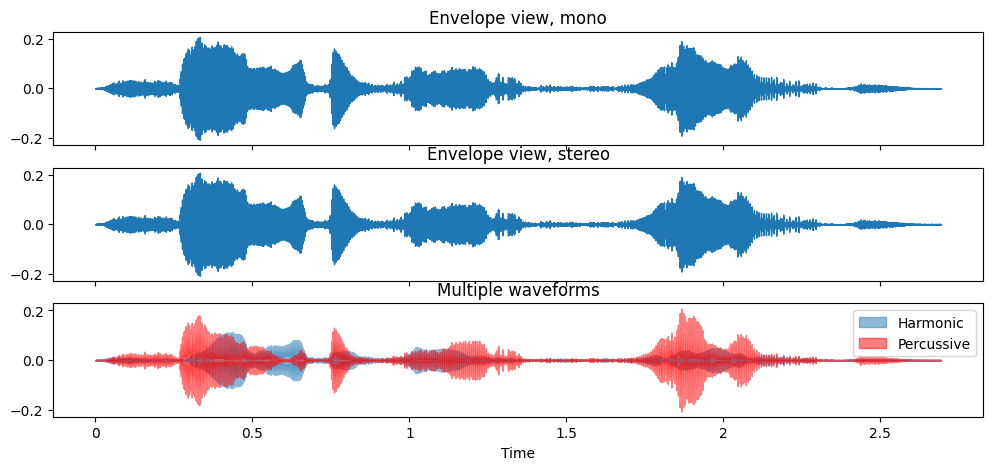

In [9]:

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(12,5))

librosa.display.waveshow(data, sr=sampling_rate, ax=ax[0])
ax[0].set(title='Envelope view, mono')
ax[0].label_outer()

librosa.display.waveshow(data2, sr=sampling_rate2, ax=ax[1])
ax[1].set(title='Envelope view, stereo')
ax[1].label_outer()

y_harm, y_perc = librosa.effects.hpss(data)
librosa.display.waveshow(y_harm, sr=sampling_rate, alpha=0.5, ax=ax[2], label='Harmonic')
librosa.display.waveshow(y_perc, sr=sampling_rate, color='r', alpha=0.5, ax=ax[2], label='Percussive')
ax[2].set(title='Multiple waveforms')
ax[2].legend()


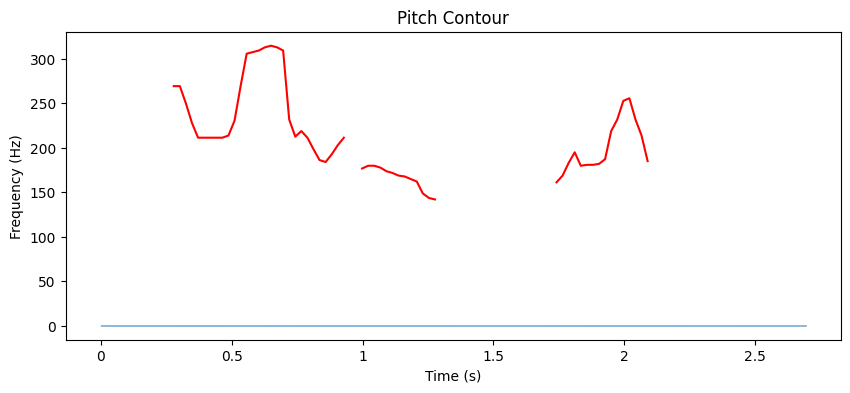

In [10]:
# Compute pitch using the PEPLOs algorithm
f0, voiced_flag, voiced_probs = librosa.pyin(data, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

# Plot pitch contour
plt.figure(figsize=(10, 4))
librosa.display.waveshow(data, sr=sampling_rate, alpha=0.5)
plt.plot(librosa.frames_to_time(range(len(f0))), f0, color='r')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Pitch Contour')
plt.show()


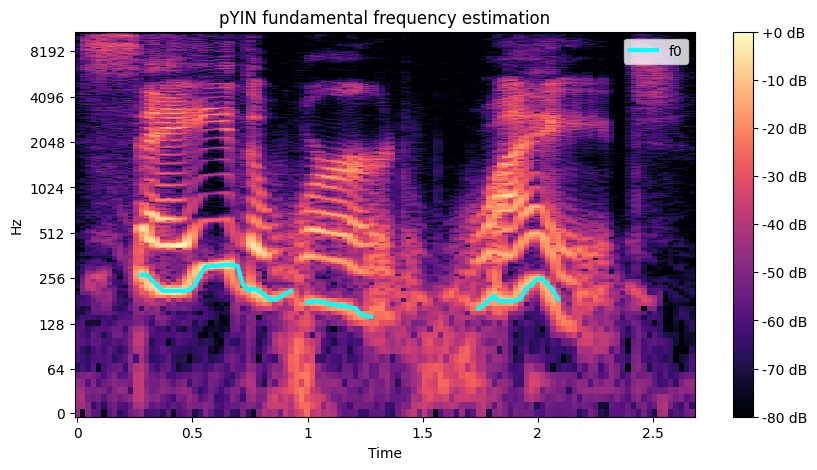

In [11]:
f0, voiced_flag, voiced_probs = librosa.pyin(data,
                                             sr=sampling_rate,
                                             fmin=librosa.note_to_hz('C2'),
                                             fmax=librosa.note_to_hz('C7'))
times = librosa.times_like(f0, sr=sampling_rate)

D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')